![](imgs/training1.png)

In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks import *
import rpsalweaklydet as rps

In [2]:
bs = 4
img_sz  = 512
crop_sz = 64
data_path = '/home/renato/data/chestxray8/'

In [19]:
# Sample small subset of the data
def sample_data(df): return pd.concat([o.sample(40) for _,o in df.groupby('is_valid')])
data = rps.data.get_chestxray8(data_path, bs, img_sz, processor=sample_data, valid_only_bbx=True)

# Loading trained model

In [20]:
model = rps.models.get_classifier(models.densenet121, 14).cuda()
model.load_state_dict(torch.load('../models/classifier_densenet121.pth'))

<All keys matched successfully>

In [50]:
# Obtain a batch of samples with bounding boxes
xb,yb = rps.data.get_bbx_samples(data.valid_dl, n_samples=8)

In [51]:
# Images, boxes      , labels
xb.shape, yb[0].shape, yb[1].shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 6, 4]), torch.Size([8, 6]))

In [52]:
saliency_layer = model[1].get_saliency_layer()

In [53]:
with torch.no_grad(), hook_output(saliency_layer) as hook:
    yb_ = model.eval()(xb.cuda())

out_saliency = hook.stored
out_saliency.shape

torch.Size([8, 14, 128, 128])

## Check heatmaps

In [54]:
# To help the visualizations we need this import
from rpsalweaklydet.structures import *

In [80]:
idx = np.random.choice(xb.size(0)) # Choose a random sample
idx

6

In [81]:
# Get the input image and label
x = data.x.reconstruct(data.denorm(xb[idx].cpu()))
y = data.y.reconstruct((yb[0][idx].cpu(),yb[1][idx].cpu()), x=x)

ylbl = '\n'.join([data.classes[o] for o in y.data[1]])
ylbl

'Atelectasis\nEffusion\nMass\nNodule'

In [82]:
# Bounding box (true label)
true_boxes = BoundingBoxLbl.from_preds(y.data, sz=img_sz, classes=data.classes)
true_boxes

BoundingBoxLbl(BoundingBox((47.14, 315.87, 135.99, 352.17), area=3225.49, sz=[512, 512]), BoundingBox((385.22, 175.54, 477.32, 449.69), area=25250.83, sz=[512, 512]), BoundingBox((266.02, 164.17, 319.66, 214.55), area=2702.68, sz=[512, 512])) [3 elements]
classes (['Atelectasis', 'Effusion', 'Mass'])

In [55]:
# Saliency maps
hms = HeatmapsLbl.from_tensor(out_saliency.sigmoid(), classes=data.classes[1:])
hm = hms[idx]
hm # Each element contains 1 heatmap for each label on our dataset

HeatmapLbl(Heatmap([128, 128]), Heatmap([128, 128]), Heatmap([128, 128]), Heatmap([128, 128]), Heatmap([128, 128]), ...) [14 elements]
14 classes (['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

In [83]:
# Bounding box (from saliency maps) 
boxes = hm.get_most_active_contours()
boxes

BoundingBoxLbl(BoundingBox((0.00, 56.00, 111.00, 111.00), area=6105.00, sz=[128, 128]), BoundingBox((23.00, 48.00, 103.00, 111.00), area=5040.00, sz=[128, 128]), BoundingBox((0.00, 56.00, 111.00, 111.00), area=6105.00, sz=[128, 128]), BoundingBox((8.00, 48.00, 55.00, 111.00), area=2961.00, sz=[128, 128]), BoundingBox((72.00, 80.00, 119.00, 119.00), area=1833.00, sz=[128, 128]), ...) [14 elements]
classes (['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

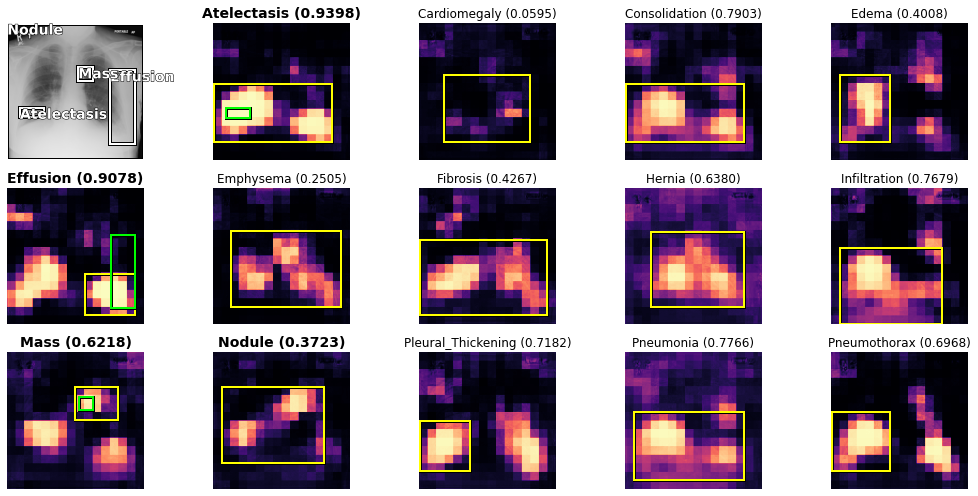

In [84]:
fig,axs = plt.subplots(3, 5, figsize=(14,7))
axs = axs.flatten()
x.show(y=y, figsize=(4,4), ax=axs[0])
hm.show(axs=axs[1:], vmin=0, vmax=1)
for ax,box,c,t in zip(axs[1:],boxes,data.classes[1:],yb_[idx].sigmoid()):
    box.draw(ax, 'yellow')
    islbl = c in ylbl
    ax.set_title(f'{c} ({t:.4f})', size=14 if islbl else 12, fontweight='bold' if islbl else 'normal')
    if islbl:
        b = true_boxes.get_class(c)
        if b is not None: b.draw(ax, color='lime', resize=hm[0].shape[0])
    
plt.tight_layout()

# Sample on how to train the model

## Using fastai

In [85]:
learn = rps.models.get_classifier_learner(data, models.densenet121)

In [86]:
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,auc_Atelectasis,auc_Cardiomegaly,auc_Consolidation,auc_Edema,auc_Effusion,auc_Emphysema,auc_Fibrosis,auc_Hernia,auc_Infiltration,auc_Mass,auc_Nodule,auc_Pleural_Thickening,auc_Pneumonia,auc_Pneumothorax,mean_auroc,time
0,0.529610,1.129208,0.496241,0.344828,0.714286,0.460526,0.641026,0.708333,nan,nan,0.408521,0.605469,0.484375,nan,0.666667,0.549784,nan,00:06


## Plain pytorch

In [87]:
model = rps.models.get_classifier(models.densenet121, 14).cuda()

In [110]:
pos_weights,neg_weights = rps.models.get_class_weights(data)
loss_func = rps.models.SaliencyMultiBCE(pos_weights, neg_weights).cuda()

In [119]:
opt = optim.Adam(model.parameters(), lr=1e-3)

In [121]:
# Example for one epoch
train_losses = []
valid_losses = []

model.train()
for xb,yb in progress_bar(data.train_dl):
    yb_ = model(xb)
    loss = loss_func(yb_, *yb)
    train_losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()
    
model.eval()
with torch.no_grad():
    for xb,yb in progress_bar(data.valid_dl):
        yb_ = model(xb)
        loss = loss_func(yb_, *yb)
        valid_losses.append(loss.item())

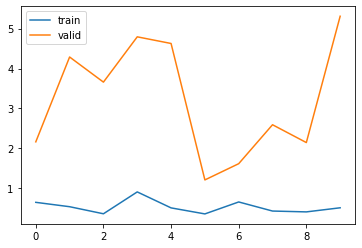

In [127]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend();